In [ ]:
import os
import tensorflow as tf
import numpy as np
import pathlib
from matplotlib import pyplot as plt
import time
import datetime
from IPython import display

In [ ]:
dataset = 'maps'

In [ ]:
dataset_file = "{}.tar.gz".format(dataset)
dataset_url = "https://efrosgans.eecs.berkeley.edu/pix2pix/datasets/{}".format(dataset_file)

In [ ]:
download_zip = tf.keras.utils.get_file(fname = dataset_file, origin = dataset_url, extract = True)

250242400/250242400 [==============================] - 15s 0us/step


In [ ]:
download_zip

PosixPath('/root/.keras/datasets/maps.tar.gz')

In [ ]:
download_zip = pathlib.Path(download_zip)
path = download_zip.parent/dataset
path

PosixPath('/root/.keras/datasets/maps')

In [ ]:
list(path.parent.iterdir())

[PosixPath('/root/.keras/datasets/maps.tar.gz'),
 PosixPath('/root/.keras/datasets/maps')]

In [ ]:
sample = tf.io.read_file(str(path / 'train/100.jpg'))
sample = tf.io.decode_jpeg(sample)

In [ ]:
print(sample.shape)
plt.figure()
plt.imshow(sample)

In [ ]:
def load_image(image_file):
  img = tf.io.read_file(image_file)
  img = tf.io.decode_jpeg(img)
  img = tf.image.resize(img, [256, 512])

  width = tf.shape(img)[1]
  width = width // 2
  orginal_image = img[:, :width, :]
  transform_image = img[:, width:, :]

  orginal_image = tf.cast(orginal_image, tf.float32)
  transform_image = tf.cast(transform_image, tf.float32)

  return orginal_image, transform_image

In [ ]:
orginal_image, transform_image = load_image(str(path / 'train/100.jpg'))
plt.figure()
plt.imshow(orginal_image / 255.0)
plt.figure()
plt.imshow(transform_image / 255.0)

In [ ]:
quantity_training = tf.data.Dataset.list_files(str(path / 'train/*.jpg'))
quantity_training

<_ShuffleDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [ ]:
quantity_training = len(list(quantity_training))
quantity_training

1096

In [ ]:
buffer_size = quantity_training
batch_size = 1
img_width = 256
img_height = 256

In [ ]:
def resize(orginal_image, transform_image, width, height):
  orginal_image = tf.image.resize(orginal_image, [width, height], method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  transform_image = tf.image.resize(transform_image, [width, height], method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return orginal_image, transform_image

In [ ]:
def normalize(orginal_image, transform_image):
  orginal_image = (orginal_image / 127.5) - 1
  transform_image = (transform_image / 127.5) - 1

  return orginal_image, transform_image

In [ ]:
def random_Crop(orginal_image, transform_image):
  stacked_image = tf.stack([orginal_image, transform_image], axis = 0)
  crop_image = tf.image.random_crop(stacked_image, [2, img_width, img_height, 3])

  return crop_image[0], crop_image[1]

In [ ]:
@tf.function()
def randomjitter(orginal_image, transform_image):
  orginal_image, transform_image = resize(orginal_image, transform_image, 286, 286)
  orginal_image, transform_image = random_Crop(orginal_image, transform_image)
  if tf.random.uniform(()) < 0.5:
    orginal_image = tf.image.flip_left_right(orginal_image)
    transform_image = tf.image.flip_left_right(transform_image)
  return orginal_image, transform_image

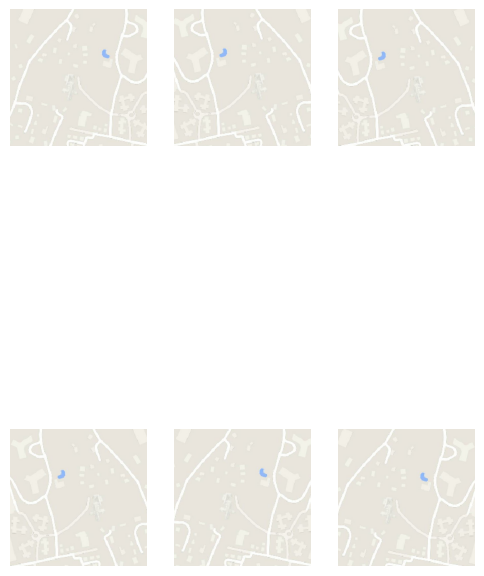

In [ ]:
plt.figure(figsize = (6, 10))
for i in range(6):
  j_org, j_trans = randomjitter(orginal_image, transform_image)
  plt.subplot(2,3, i + 1)
  plt.imshow(j_trans / 255.0)
  plt.axis('off')
plt.show()

In [ ]:
def load_training_dataset(image_file):
  orginal_image, transform_image = load_image(image_file)
  orginal_image, transform_image = randomjitter(orginal_image, transform_image)
  orginal_image, transform_image = normalize(orginal_image, transform_image)

  return orginal_image, transform_image

In [ ]:
def load_testing_dataset(image_file):
  orginal_image, transform_image = load_image(image_file)
  orginal_image, transform_image = resize(orginal_image, transform_image, img_width, img_height)
  orginal_image, transform_image = normalize(orginal_image, transform_image)

  return orginal_image, transform_image

In [ ]:
training_dataset = tf.data.Dataset.list_files(str(path / 'train/*.jpg'))
training_dataset = training_dataset.map(load_training_dataset,  )
training_dataset = training_dataset.shuffle(buffer_size)
training_dataset = training_dataset.batch(batch_size)

In [ ]:
training_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None))>

In [ ]:
try:
  testing_dataset = tf.data.Dataset.list_files(str(path / 'test/*.jpg'))
except tf.errors.InvalidArgumentError:
  testing_dataset = tf.data.Dataset.list_files(str(path / 'val/*.jpg'))
testing_dataset = testing_dataset.map(load_testing_dataset)
testing_dataset = testing_dataset.batch(batch_size)

In [ ]:
def encode(filters, size, apply_batchnorm = True):
  initializer = tf.random_normal_initializer(0, 0.02)
  model = tf.keras.Sequential()

  model.add(tf.keras.layers.Conv2D(filters, size, strides = 2, padding = 'same',
                                   kernel_initializer = initializer, use_bias = False))
  if apply_batchnorm:
    model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.LeakyReLU())

  return model

In [ ]:
down_model = encode(3, 4)
dow_result = down_model(tf.expand_dims(orginal_image, 0))
print(dow_result.shape)

(1, 128, 128, 3)


In [ ]:
def decode(filters, size, apply_dropout = False):
  initializer = tf.random_normal_initializer(0, 0.02)
  model = tf.keras.Sequential()

  model.add(tf.keras.layers.Conv2DTranspose(filters, size, strides = 2, padding = 'same',
                                            kernel_initializer = initializer, use_bias = False))
  model.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
    model.add(tf.keras.layers.Dropout(0.5))

  model.add(tf.keras.layers.ReLU())

  return model

In [ ]:
up_model = decode(3, 4)
up_result = up_model(dow_result)
print(up_result.shape)

(1, 256, 256, 3)


In [ ]:
def Generator():
  inputs = tf.keras.layers.Input(shape = [256, 256, 3])

  downsampling = [
      encode(64, 4, apply_batchnorm = False),
      encode(128, 4), # 64 64 128
      encode(256, 4), # 32 32 256
      encode(512, 4), # 16 16 512
      encode(512, 4), # 8 8 512
      encode(512, 4), # 4 4 512
      encode(512, 4), # 2 2 512
      encode(512, 4), # 1 1 512
  ]

  upsampling = [
      decode(512, 4, apply_dropout = True), # 2 2 512
      decode(512, 4, apply_dropout = True), # 4 4 512
      decode(512, 4, apply_dropout = True), # 8 8 512
      decode(512, 4), # 16 16 512
      decode(256, 4), # 32 32 256
      decode(128, 4), # 64 64 128
      decode(64, 4), # 128 128 64
  ]

  output_channels = 3
  initializer = tf.random_normal_initializer(0, 0.02)
  last = tf.keras.layers.Conv2DTranspose(output_channels, 4, strides = 2, padding = 'same',
                                         kernel_initializer = initializer, activation = 'tanh') # 256 256 3


  x = inputs
  skips = []
  for down in downsampling:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  for up, skip in zip(upsampling, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs = inputs, outputs = x)

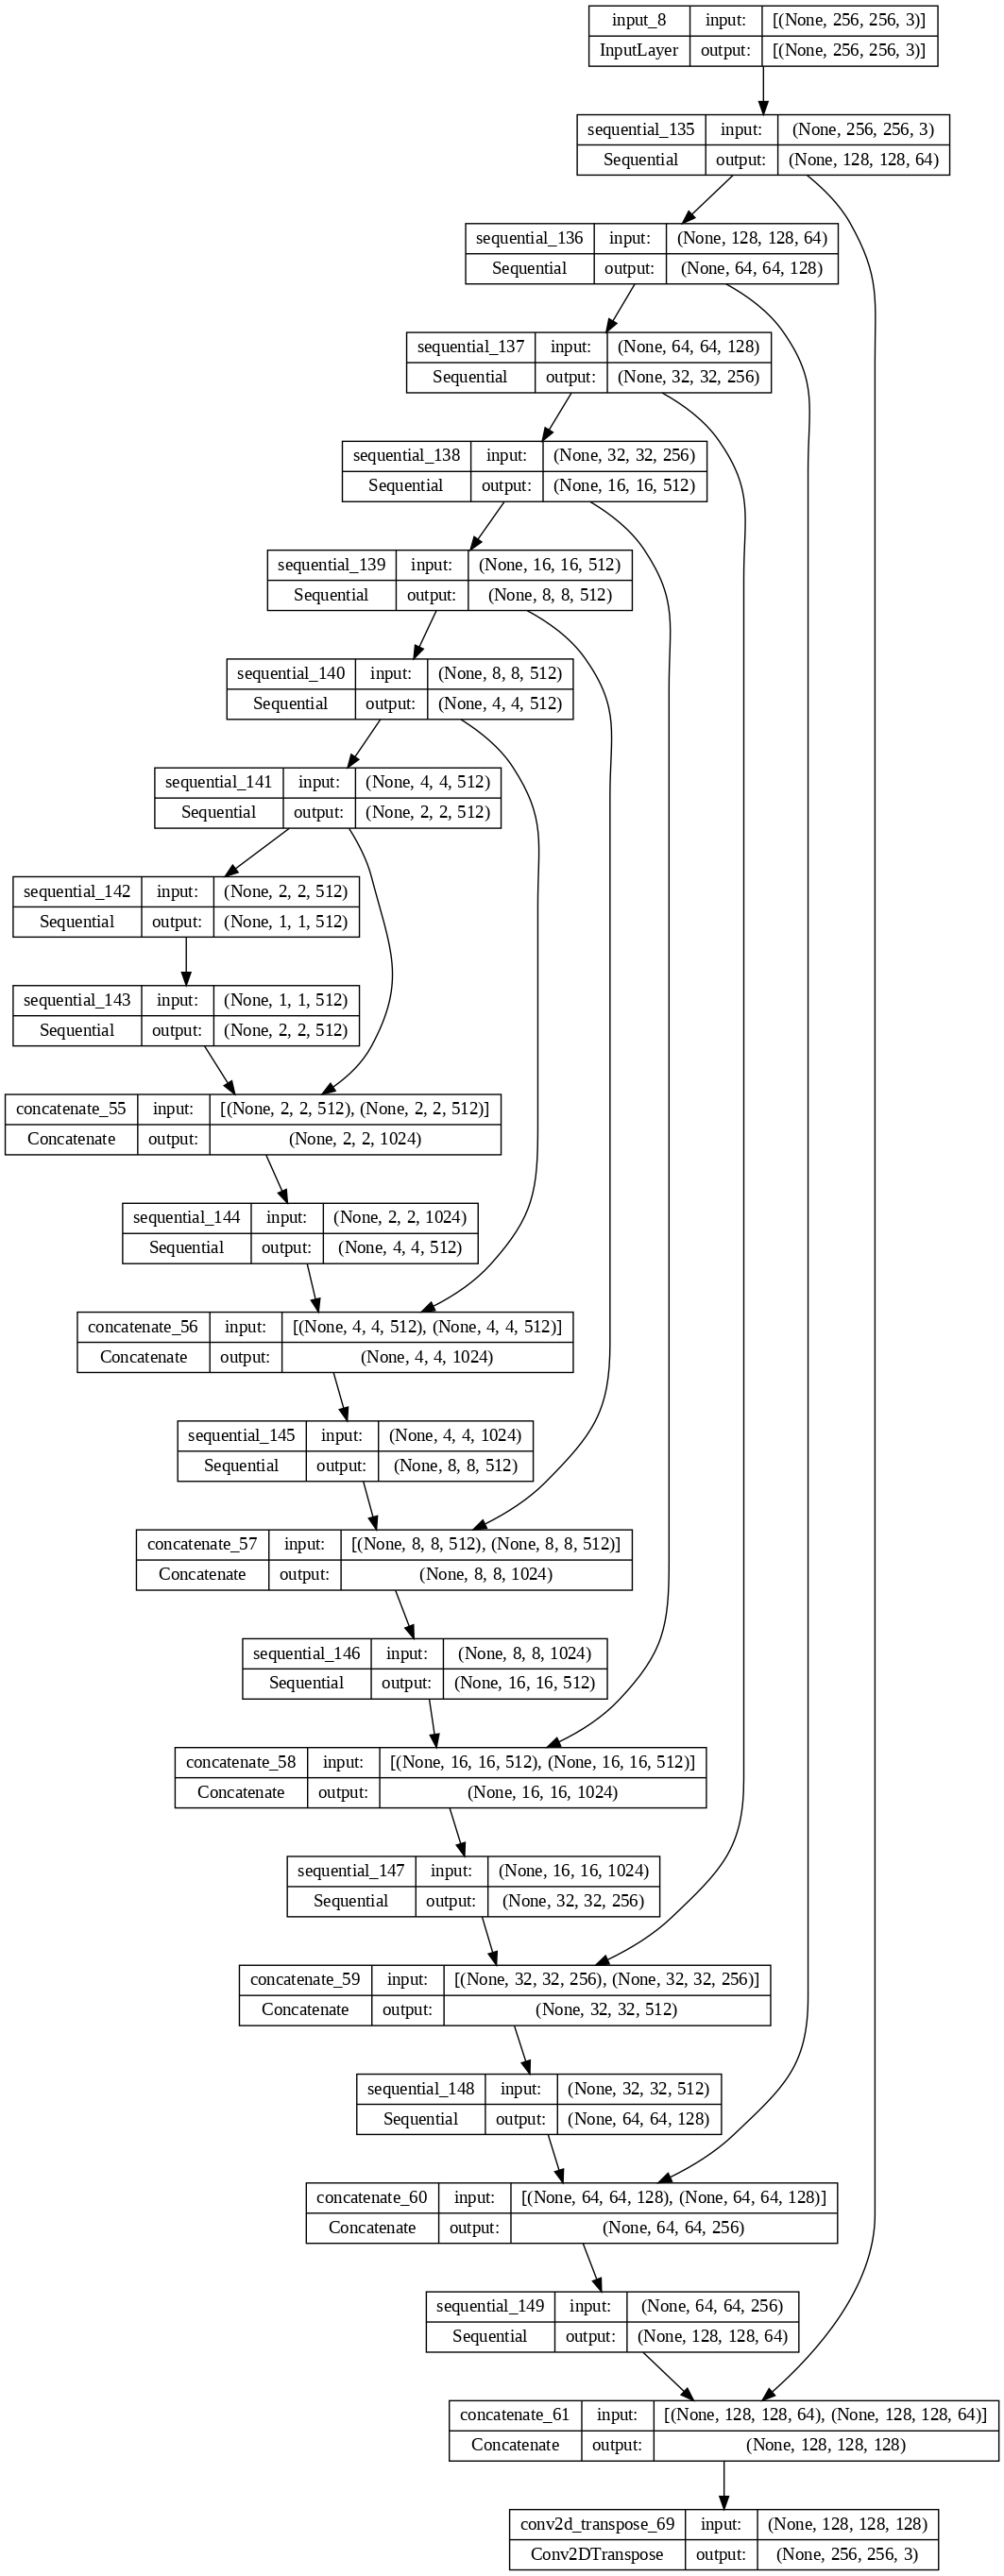

In [ ]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes = True, dpi = 100)

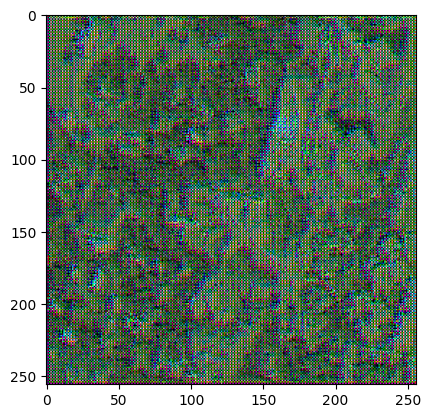

In [ ]:
g_output = generator(orginal_image[tf.newaxis, ...], training = False)
plt.imshow(g_output[0, ...])

In [ ]:
lr = 0.0002
beta1, beta2 = 0.5, 0.999
lambda_ = 100

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [ ]:
def generator_loss(d_generator_output, g_output, target):
  gan_loss = loss(tf.ones_like(d_generator_output), d_generator_output)
  l1_loss = tf.reduce_mean(tf.abs(target - g_output)) # Mean ABS
  g_loss_total = gan_loss + (lambda_ * l1_loss)

  return g_loss_total, gan_loss, l1_loss

In [ ]:
def discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)
  orginal = tf.keras.layers.Input(shape = [256, 256, 3], name = 'orginal_img')
  transformed = tf.keras.layers.Input(shape = [256, 256, 3], name = 'transformed_img')
  x = tf.keras.layers.concatenate([orginal, transformed])

  down1 = encode(64, 4, False)(x)
  down2 = encode(128, 4)(down1)
  down3 = encode(256, 4)(down2)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)
  conv = tf.keras.layers.Conv2D(512, 4, strides = 1, kernel_initializer = initializer, use_bias = False)(zero_pad1)
  batchnorm = tf.keras.layers.BatchNormalization()(conv)
  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm)
  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)
  last = tf.keras.layers.Conv2D(1, 4, strides = 1, kernel_initializer = initializer)(zero_pad2)

  return tf.keras.Model(inputs = [orginal, transformed], outputs = last)

In [ ]:
discriminator = discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes = True, dpi = 100)

In [ ]:
d_output = discriminator([orginal_image[tf.newaxis, ...], g_output], training = False)
plt.imshow(d_output[0,...,-1])

In [ ]:
def discriminator_loss(d_real_output, d_generated_output):
  real_loss = loss(tf.ones_like(d_real_output), d_real_output)
  generated_loss = loss(tf.zeros_like(d_generated_output), d_generated_output)
  d_total_loss = real_loss + generated_loss

  return d_total_loss

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(lr, beta_1 = beta1, beta_2 = beta2)
discriminator_optimizer = tf.keras.optimizers.Adam(lr, beta_1 = beta1, beta_2 = beta2)

In [ ]:
checkpoint_dir = './training_chekpoints'
checkpoint_prefix = os.path.join(checkpoint_dir , "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)

In [ ]:
def generate_images(model, test_input, real, step = None):
  generated_images = model(test_input, training = True)
  plt.figure(figsize = (12,8))

  img_list = [test_input[0], real[0], generated_images[0]]
  title = ['Inpute image', 'Real (ground truth)', 'Generated Images (fake)']

  for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.title(title[i])
    plt.imshow(img_list[i] * 0.5 + 0.5)
    plt.axis('off')

  if step is not None:
    plt.savefig('result_pix2pix_step{}.png'.format(step), bbox_inches = 'tight')

  plt.show()

In [ ]:

for inpute_example, real_example in testing_dataset.take(2):
  generate_images(generator, inpute_example, real_example)

In [ ]:
path_log = 'logs/'
metrics = tf.summary.create_file_writer(path_log + 'fit/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [ ]:
@tf.function()
def training_step(input_img, real, step):
  with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
    g_output = generator(input_img, training = True)

    d_output_real = discriminator([input_img, real], training = True)
    d_output_generated = discriminator([input_img, g_output], training = True)

    g_total_loss, g_loss_gan, g_loss_l1 = generator_loss(d_output_generated, g_output, real)
    d_loss = discriminator_loss(d_output_real, d_output_generated)

  generator_gradient = g_tape.gradient(g_total_loss, generator.trainable_variables)
  discriminator_gradient = d_tape.gradient(d_loss, discriminator.trainable_variables)

  with metrics.as_default():
    tf.summary.scalar('g_total_loss', g_total_loss, step = step // 1000)
    tf.summary.scalar('g_loss_gan', g_loss_gan, step = step // 1000)
    tf.summary.scalar('g_loss_l1', g_loss_l1, step = step // 1000)
    tf.summary.scalar('d_loss', d_loss, step = step // 1000)

In [ ]:
def train(training_dataset, testing_dataset, steps):
  test_input, real_input = next(iter(testing_dataset.take(1)))
  start = time.time()

  for step, (input_img, real_img) in testing_dataset.repeat().take(steps).enumerate():
    if step % 1000 == 0:
      display.clear_output(wait = True)
      if step != 0:
        print(f'Time taken to run 1000 steps: {time.time() - start:.2f} secends\n')
      start = time.time()
      generate_images(generator, test_input, real_input, step)
      print(f'Step: {step//1000}K')
    training_step(input_img, real_img, step)
    if(step + 1) % 10 == 0:
      print('.', end = '', flush = True)
    if(step + 1) % 5000 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
      generator.save_weights('model_pix2pix.h5')

In [ ]:
%load_ext tensorboard
%tensorboard --logdir {path_log}

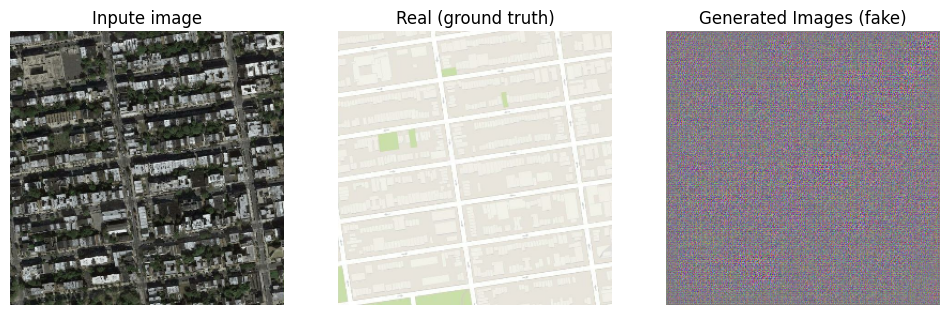

Step: 6K
.......................................................................................

In [ ]:
train(training_dataset, testing_dataset, steps = 40000)